In [2]:
import numpy as np
import pandas as pd
import torch
import sklearn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as du
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.manifold import TSNE
from tqdm import tqdm
from torch.utils import data
from collections import defaultdict
from torch.utils.data import Dataset
from torchvision import datasets, transforms

Exploratory Data Analysis for Students and Tutors

In [ ]:
url_student = 'https://raw.githubusercontent.com/Instantutor/Instantutor-Research/main/Datasets/Data.csv'
student = pd.read_csv(url_student)
student.head()

In [ ]:
student.drop(['Category(Mentor/Mentee/Both)', 'Degree', 'Course'], axis = 1, inplace = True)
student.head()

In [ ]:
url_rating = 'https://raw.githubusercontent.com/Instantutor/Instantutor-Research/main/Datasets/Rating.csv'
rating = pd.read_csv(url_rating)
rating.head()

In [ ]:
rating.drop(['Mentee', 'Time stamp', 'Comments'], axis = 1, inplace = True)
rating.head()

In [ ]:
print(student['Area'].value_counts())
print(student['Time zone'].value_counts())

In [ ]:
# Obtain all possible labels for each column to be generated
possible_areas = student['Area'].unique()
possible_zones = student['Time zone'].unique()
possible_times = ["0:00", "1:00", "2:00", "3:00", "4:00", "5:00", "6:00", "7:00", "8:00", "9:00", "10:00", "11:00", 
                  "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"] 
possible_genders = ['F', 'M']

student_rows = student['Area'].size
rating_rows = rating['Mentor'].size

# Obtain the distribution
spreads = student['Area'].value_counts()
distribution = spreads.div(student_rows)
print(distribution)

In [ ]:
# Only Area generation is weighted. Other data generation will be uniformly distributed.
rating['gender'] = np.random.choice(possible_genders, rating_rows)
rating['Area'] = np.random.choice(possible_areas, rating_rows, p = distribution.values)
rating['Time zone'] = np.random.choice(possible_zones, rating_rows)
rating['Availability time start'] = np.random.choice(possible_times, rating_rows)
rating['Availability time end'] = np.random.choice(possible_times, rating_rows)

# View the new ratings data
rating.head()

In [ ]:
# Store the mentor:rating pairs as a dictionary for future access
mentor_to_rating = rating.groupby('Mentor')['Rating'].apply(list).to_dict()

# Drop the rating column
rating.drop('Rating', axis = 1, inplace = True)

We will use a classification task to train our embeddings. To do so, we will create positive pairs using collaborative filtering
and randomly sampled negative pairs. For each user, we want to create 3 positive samples and 15 negative samples. We can choose to pass these as batches.

In [ ]:
gender_to_val = {possible_genders[i]:i for i in range(len(possible_genders))}
area_to_val = {'IT' : 0, 'Computer Science': 3, 'Math': 9, 'Physics': 11 ,'Aerospace': 13,
               'Science': 20, 'Chemical Engineering': 24, 'Materials Science': 29,
               'Biology': 30, 'Chemistry': 24, 'Geology': 45,
               'English': 68, 'French': 77, 'Spanish': 82,
               'Arabic': 88, 'Quran': 95, 'History': 110}
               
time_to_val = {'Asia': 0, 'Europe': 20, 'Africa': 40, 'Australia': 60, 'Antarctica': 70, 'North America': 80, 'Central': 90, 'Pacific': 100}
avail_to_val = {possible_times[i]:i  for i in range(len(possible_times))}

In [ ]:
# Replace any non numerical values according to the dictionary.
student = student.replace(gender_to_val)
student = student.replace(area_to_val)
student = student.replace(time_to_val)
student = student.replace(avail_to_val)

# Visualize the user data
student.head()

In [ ]:
rating = rating.replace(gender_to_val)
rating = rating.replace(area_to_val)
rating = rating.replace(time_to_val)
rating = rating.replace(avail_to_val)

# Visualize the rating data
rating.head()

In [ ]:
# Make a mapping of users and tutors to indicies. This way, we can keep track of the books. Also create a reverse mapping.
list_tutors = rating['Mentor'].tolist()
list_users = student['id_student'].tolist()

# Create mappings for users
idx_to_user = {index: user for (index, user) in enumerate(list_users)}
user_to_idx = {user: index for (index, user) in enumerate(list_users)}

# Create mappings for tutors
idx_to_tutor = {index: tutor for (index, tutor) in enumerate(list_tutors)}
tutor_to_idx = {tutor: index for (index, tutor) in enumerate(list_tutors)}

In [ ]:
# Remove duplicate student ids or tutor ids.
duplicate_users = student[student.duplicated(subset = 'id_student', keep = 'first')]
duplicate_tutors = rating[rating.duplicated(subset = 'Mentor', keep = 'first')]

# Drop the duplicate students and users
student.drop(index = duplicate_users.index, inplace = True)
rating.drop(index = duplicate_tutors.index, inplace = True)

# Since we have a mapping now, we can remove the ids from the dataframe.
final_user = student.drop('id_student', axis = 1, inplace = False)
final_tutor = rating.drop('Mentor', axis = 1, inplace = False)

Then, we can generate positive and negative samples through collaborative filtering.
When selecting positive samples, cosine similarity will be weighted based on the following adjustable criteria:
* Gender: 5%
* Area: 65%
* Time Zone: 15%
* Availability Time Start: 10%
* Availability Time End: 5%

In [ ]:
weights = [0.05, 0.65, 0.15, 0.10, 0.05]

In [ ]:
def weighted_Norm(user, tutor, weights):
    '''
    Calculate a weighted euclidean distance given a user and a tutor.
    Since we are using distance, we can simply set student rating to 1 as default and ratings from 0 to 5 as 0 - 1 respectively.
    '''
    dist = user-tutor
    weighted_dist = np.sqrt(np.dot(weights,np.dot(dist, dist)).sum())
    return weighted_dist

In [ ]:
class UserTutorDataset(torch.utils.data.Dataset):
    def __init__(self, pos_samples, neg_samples, users, tutors, weights):
        '''
        pos_samples - The number of positive samples to create per user.
        neg_samples - The number of negative samples to create per user.
        users - A dataset consisting of users and their attributes(gender, area, timezone, availability times).
        tutors - A dataset consisting of tutors and their attributes.
        weights - An array-like of weights for each attribute of a user/tutor. This gives us more information on which attributes are more important.
        '''
        super(UserTutorDataset, self).__init__()
        
        self.pos_samples = pos_samples
        self.neg_samples = neg_samples
        self.users = users
        self.tutors = tutors
        self.weights = weights
        
        # precompute all distances and store in a dictionary.       
        self.dists = {user_idx:[weighted_Norm(self.users[user_idx], tutor, self.weights) for tutor in self.tutors] for user_idx in tqdm(range(len(self.users)))}
        
    def get_pairs(self, user):
        ''' given a user, generate positive and negative pairs for that user '''
        
        #obtain the similarity of the user to every tutor.
        distances = self.dists[user
                               
        #obtain indicies of the lowest num_pos distances in linear time
        pos_pairs = np.argpartition(distances, self.pos_samples)[:self.pos_samples]
        
        # Randomly obtain negative samples from the 500 least similiar tutors.
        min_five = np.argpartition(distances, -500)[-500:]
        neg_pairs = np.random.choice(min_five, self.neg_samples)
        
        # Generate an array of labels.
        labels = np.zeros(self.pos_samples + self.neg_samples)
        labels[0:self.pos_samples] = 1
                               
        return pos_pairs, neg_pairs, labels
        
    def __len__(self):
        '''
        Return the total number of users.
        '''
        return len(self.users)
    
    def __getitem__(self, idx):
        '''
        Return a tensor of positive and negative tutor samples along with a tensor of targets given a user index.
        '''
        pos_pairs, neg_pairs, labels = self.get_pairs(idx)
        pos_pairs = torch.tensor(pos_pairs)
        neg_pairs = torch.tensor(neg_pairs)
        total_pairs = torch.cat((pos_pairs, neg_pairs), dim = 0)
        labels = torch.tensor(labels)
        
        # Create a tensor of targets(user)
        targets = torch.full(total_pairs.shape, idx)
        return targets, total_pairs, labels

In [ ]:
def visualize_embeddings(embeddings, feature, rating, embedding_dim, mode):
    '''
    Given a learned embedding, a dataframe, and the feature to display by, 
    display a tsne-visualization of the embeddings and then 
    the embeddings by feature if feature is not none.
    '''
    
    # Reduce the embeddings to 2 dimensions using a manifold.
    reduced_embedding = TSNE(3, perplexity = 50, learning_rate = 'auto', init = 'pca', metric = 'euclidean').fit_transform(embeddings)
    
    plt.figure(figsize = (12.4,9.92))
    plt.plot(reduced_embedding[:, 0], reduced_embedding[:, 1], reduced_embedding[:,2], '.g')
    if mode == 'User':
        plt.title("User Embeddings")
    else:
        plt.title("Tutor Embeddings")
    plt.show()
    
    
    if feature != 'None' and feature in rating.columns:
        # Obtain all labels for that feature
        plt.figure(figsize = (18,12))
        all_labels = rating[feature]
        color_labels, unique_feats  = pd.factorize(all_labels)
        
        new_colors = plt.cm.tab20(np.linspace(0.0, 1.0, 17))
        new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", new_colors)

        plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], reduced_embedding[:,2],
                    c = color_labels, cmap = new_cmap)
        
        # Display a key on the side
        color_bar = plt.colorbar()
        color_bar.set_ticks([])
        
        for idx, feats in enumerate(unique_feats):
            color_bar.ax.text(1, (2 * idx + 1)/((10)*2), feats, ha = 'left', va = 'center')
        color_bar.ax.set_title(feature, loc = 'left')
        plt.xlabel("Embedding Axis 1")
        plt.ylabel("Embedding Axis 2")
        if mode == 'User':
            plt.title("Colored User Embeddings")
        else:
            plt.title("Colored Tutor Embeddings")
        
        plt.show()

In [ ]:
class TwoTower(nn.Module):
    '''
    This class creates and learns an embedding representation for
    both tutors and users.
    '''
    def __init__(self, num_user, user_features, num_tutors, tutor_features, in_dim, hidden_dim, out_dim):
        super(TwoTower, self).__init__()
        
        # Initialize the embeddings
        self.user_embedding = nn.Embedding(num_user, user_features)
        self.tutor_embedding = nn.Embedding(num_tutors, tutor_features)
        
    def forward(self, user_idx, tutor_idx):
        
        # Obtain embeddings of the user and tutor
        embed_u = self.user_embedding(user_idx)
        embed_t = self.tutor_embedding(tutor_idx)
        
        # Instead of taking sigmoid here, we can just find the loss with logits.
        output = torch.sum(embed_u * embed_t, dim = 2)
        return output

Begin the Classification Task to train the embeddings.
* All duplicate tutors and users have been removed from their respective dataframes.
* We can include the number of times a tutor has helped a student as another feature in the dataframe if necessary.

In [ ]:
# Parameters
POS_SAMPLES = 4
NEG_SAMPLES = 15
IN_DIM = 5
HIDDEN_DIM = 32
OUT_DIM = num_pos_samples*num_neg_samples
EPOCHS = 30
LEARNING_RATE = 0.001
BATCH_SIZE = 1

users = final_user.to_numpy()
tutors = final_tutor.to_numpy()
feat_weights = weights
num_users = final_user.shape[0]
num_tutors = final_tutor.shape[0]
num_user_features = final_user.shape[1]
num_tutor_features = final_tutor.shape[1]
out_dim = num_pos_samples*num_neg_samples

In [ ]:
# Pick the device
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

In [ ]:
# Create the train data and load it into the dataloader
train_data = UserTutorDataset(POS_SAMPLES, NEG_SAMPLES, 
                              users, tutors, feat_weights)

train_loader = du.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)

model = TwoTower(num_users, num_user_features, num_tutors, 
                 num_tutor_features, IN_DIM, HIDDEN_DIM, OUT_DIM)

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Set the mode to train
model = model.to(device)
model.train()

In [23]:
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, EPOCHS):
    sum_loss = 0.
    for batch_idx, (targets, total_pairs, labels) in enumerate(tqdm(train_loader)):
        targets, total_pairs, labels = targets.to(device), total_pairs.to(device), labels.to(device)
        
        # zero out prevous gradients
        model.zero_grad()
        
        # predict with the model
        prediction = model(targets, total_pairs)

        # calculate loss
        loss = loss_func(prediction, labels.float())
        sum_loss += loss.item()
        
        # backpropagate and step.
        loss.backward()
        optimizer.step()
    
    sum_loss /= (len(train_loader)*15) # Divide by the total number of samples.
    print(f"Epoch: {epoch}/{EPOCHS}, Loss: {sum_loss:.6f}")

100%|██████████| 28785/28785 [02:57<00:00, 162.07it/s]


Epoch: 1/30, Loss: 0.064132


100%|██████████| 28785/28785 [02:56<00:00, 162.69it/s]


Epoch: 2/30, Loss: 0.051753


100%|██████████| 28785/28785 [02:43<00:00, 176.42it/s]


Epoch: 3/30, Loss: 0.048454


100%|██████████| 28785/28785 [02:43<00:00, 176.20it/s]


Epoch: 4/30, Loss: 0.047406


100%|██████████| 28785/28785 [03:04<00:00, 155.82it/s]


Epoch: 5/30, Loss: 0.046838


100%|██████████| 28785/28785 [02:49<00:00, 169.99it/s]


Epoch: 6/30, Loss: 0.046211


100%|██████████| 28785/28785 [02:44<00:00, 174.92it/s]


Epoch: 7/30, Loss: 0.045425


100%|██████████| 28785/28785 [02:27<00:00, 195.02it/s]


Epoch: 8/30, Loss: 0.044421


100%|██████████| 28785/28785 [02:54<00:00, 165.02it/s]


Epoch: 9/30, Loss: 0.043230


100%|██████████| 28785/28785 [02:35<00:00, 185.16it/s]


Epoch: 10/30, Loss: 0.041811


100%|██████████| 28785/28785 [02:43<00:00, 175.93it/s]


Epoch: 11/30, Loss: 0.040229


100%|██████████| 28785/28785 [02:31<00:00, 189.58it/s]


Epoch: 12/30, Loss: 0.038454


100%|██████████| 28785/28785 [02:45<00:00, 174.19it/s]


Epoch: 13/30, Loss: 0.036665


100%|██████████| 28785/28785 [02:14<00:00, 214.70it/s]


Epoch: 14/30, Loss: 0.034728


100%|██████████| 28785/28785 [02:25<00:00, 198.47it/s]


Epoch: 15/30, Loss: 0.032801


100%|██████████| 28785/28785 [02:55<00:00, 164.34it/s]


Epoch: 16/30, Loss: 0.030726


100%|██████████| 28785/28785 [02:42<00:00, 177.55it/s]


Epoch: 17/30, Loss: 0.028777


100%|██████████| 28785/28785 [02:10<00:00, 220.17it/s]


Epoch: 18/30, Loss: 0.026801


100%|██████████| 28785/28785 [02:28<00:00, 193.99it/s]


Epoch: 19/30, Loss: 0.024837


100%|██████████| 28785/28785 [01:56<00:00, 247.95it/s]


Epoch: 20/30, Loss: 0.022909


100%|██████████| 28785/28785 [02:12<00:00, 217.49it/s]


Epoch: 21/30, Loss: 0.021077


100%|██████████| 28785/28785 [02:10<00:00, 220.05it/s]


Epoch: 22/30, Loss: 0.019330


100%|██████████| 28785/28785 [02:31<00:00, 189.38it/s]


Epoch: 23/30, Loss: 0.017643


100%|██████████| 28785/28785 [02:35<00:00, 184.84it/s]


Epoch: 24/30, Loss: 0.016088


100%|██████████| 28785/28785 [02:44<00:00, 174.77it/s]


Epoch: 25/30, Loss: 0.014613


100%|██████████| 28785/28785 [02:14<00:00, 214.30it/s]


Epoch: 26/30, Loss: 0.013168


100%|██████████| 28785/28785 [02:08<00:00, 223.64it/s]


Epoch: 27/30, Loss: 0.011946


100%|██████████| 28785/28785 [01:59<00:00, 241.72it/s]


Epoch: 28/30, Loss: 0.010730


100%|██████████| 28785/28785 [02:10<00:00, 220.08it/s]

Epoch: 29/30, Loss: 0.009665


In [25]:
# Save the model
SAVE_KEY = True
LOAD_PREV = True

if SAVE_KEY:
    torch.save(model, "user_tutor_embed.pth")

if LOAD_PREV:
    model = torch.load("user_tutor_embed.pth")
    model.train()

In [26]:
for name, p in model.named_parameters():
    if name == 'user_embedding.weight':
        user_embeddings = p.cpu().data.numpy()
    if name == 'tutor_embedding.weight':
        tutor_embeddings = p.cpu().data.numpy()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


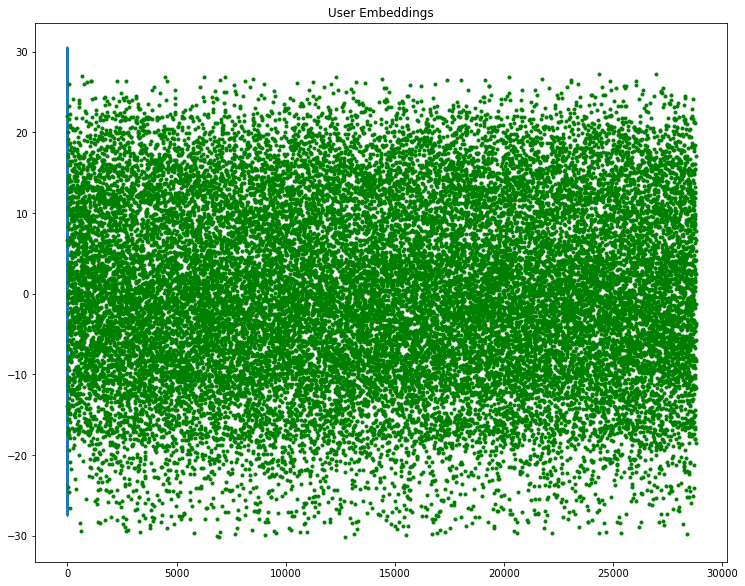

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


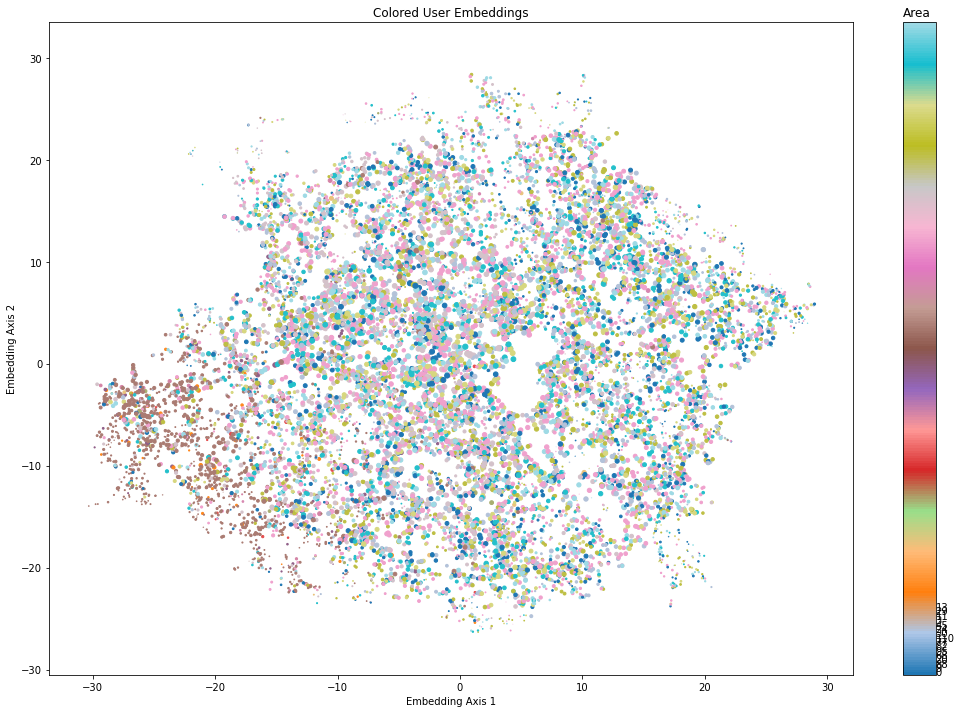

In [27]:
# Plot the user embeddings by area
visualize_embeddings(user_embeddings, 'Area', student, num_user_features, 'User')

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


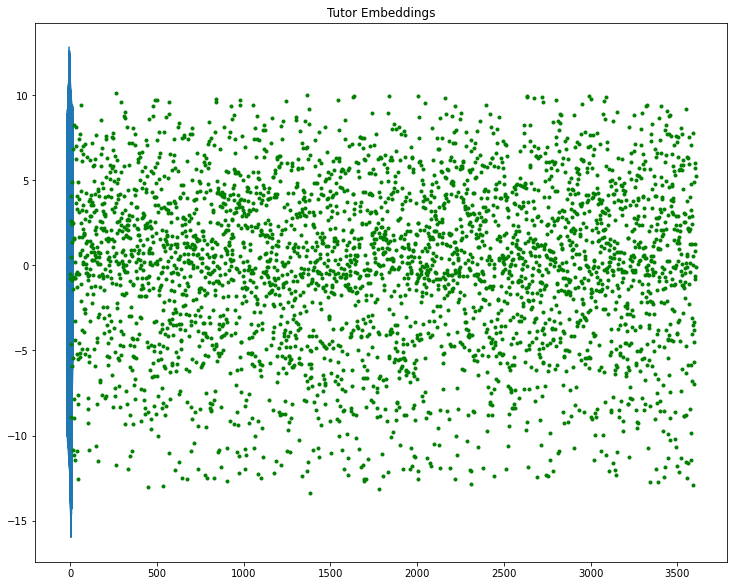

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


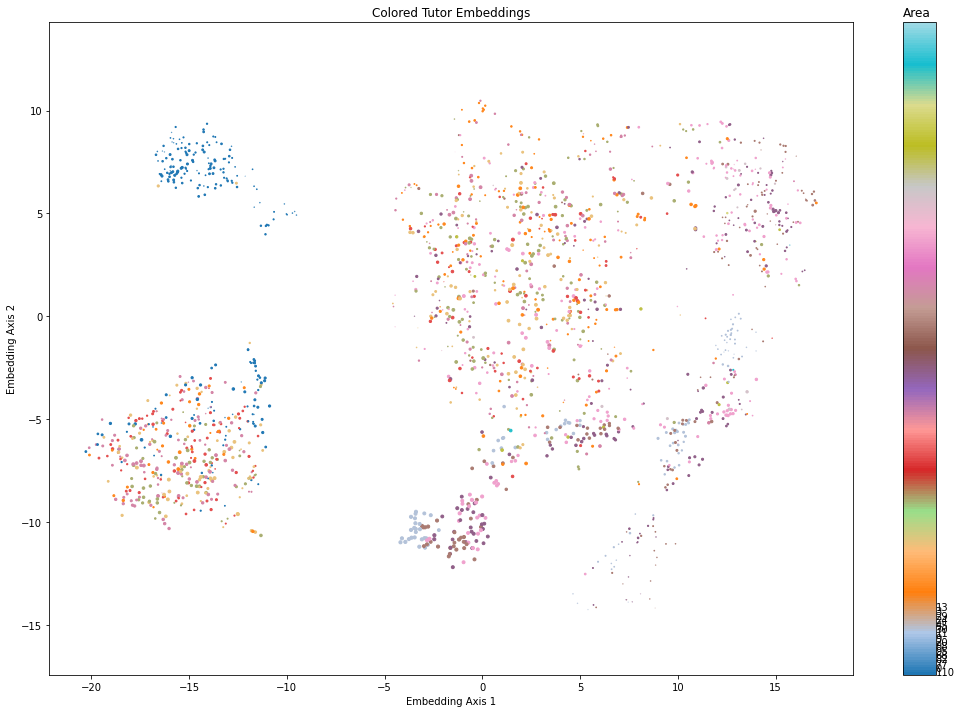

In [28]:
# Visualize tutor embeddings
visualize_embeddings(tutor_embeddings, 'Area', rating, num_tutor_features, 'Tutor')

Implement K-NN to recommend users tutors

In [29]:
def KNN(user, embeddings, k, ratings, idx_to_user):
    """
    Finds and returns the k nearest neighbors of the given user from the embeddings.
    user: the index of the user
    embeddings: the learned weights of all the users(must include user)
    k: the nubmer of nearest neighbors to find.
    ratings: a mapping of idx to a user's features
    idx_to_user: a mapping of indicies to user id
    """
    # Calculate all distances using cosine similarity making sure to check for user validity
    try:
        n_dists = np.dot(embeddings, embeddings[user].T)
        n_dists = n_dists.T
    except KeyError:
        print("This user has yet to learn an embedding in the system.")
        return False
    
    # Find the closest k indicies for each user. 19 x 28785 - > 19 x k
    sorted_dists = np.argsort(n_dists, axis = -1)[:,:k]
    print(sorted_dists)
    
    # Retrieve user ids and ratings
    ids = idx_to_user[sorted_dists]
    id_feats = ratings[sorted_dists]
    
    # Retrieve and return the features of the recommended users
    return {ids[i]:id_feats[i] for i in range(len(ids))} 

Evaluate the Model

In [30]:
model.eval()
sum_loss = 0.

for batch_idx, (targets, total_pairs, labels) in enumerate(tqdm(train_loader)):
    targets, total_pairs, labels = targets.to(device), total_pairs.to(device), labels.to(device)

    #predict with the model
    prediction = KNN(targets.squeeze(), user_embeddings, 3, student, idx_to_user)
    print(prediction)
    break

  0%|          | 0/28785 [00:00<?, ?it/s]


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
#error: targets are all the same index
#we have a multidimensional output for kmeans so we cant use dictionary to convert idx to user.
#support batch training